In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import torch
import os

# ---------------------------
# Lorenz system definition
# ---------------------------
def lorenz(t, state, sigma, beta, r):
    x, y, z = state
    dxdt = sigma * (y - x)
    dydt = x * (r - z) - y
    dzdt = x * y - beta * z
    return [dxdt, dydt, dzdt]

# ---------------------------
# Simulate Lorenz system
# ---------------------------
def simulate_lorenz(sigma, beta, r, initial_state, t_span=(0, 40), dt=0.01):
    t_eval = np.arange(t_span[0], t_span[1], dt)
    sol = solve_ivp(
        lorenz, t_span, initial_state, args=(sigma, beta, r),
        t_eval=t_eval, rtol=1e-8, atol=1e-10
    )
    return sol.t, sol.y

Simulating for r = 1.0
Simulating for r = 1.1
Simulating for r = 1.2000000000000002
Simulating for r = 1.3000000000000003
Simulating for r = 1.4000000000000004
Simulating for r = 1.5000000000000004
Simulating for r = 1.6000000000000005
Simulating for r = 1.7000000000000006
Simulating for r = 1.8000000000000007
Simulating for r = 1.9000000000000008
Simulating for r = 2.000000000000001
Simulating for r = 2.100000000000001
Simulating for r = 2.200000000000001
Simulating for r = 2.300000000000001
Simulating for r = 2.4000000000000012
Simulating for r = 2.5000000000000013
Simulating for r = 2.6000000000000014
Simulating for r = 2.7000000000000015
Simulating for r = 2.8000000000000016
Simulating for r = 2.9000000000000017
Simulating for r = 3.0000000000000018
Simulating for r = 3.100000000000002
Simulating for r = 3.200000000000002
Simulating for r = 3.300000000000002
Simulating for r = 3.400000000000002
Simulating for r = 3.500000000000002
Simulating for r = 3.6000000000000023
Simulating fo

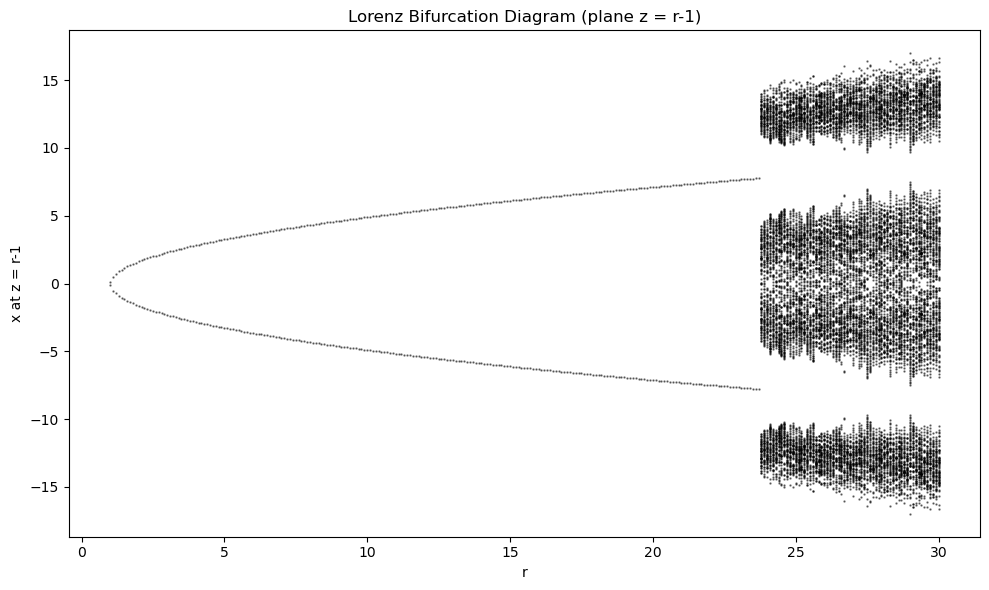

In [15]:

# Parameters
sigma = 10.0
beta = 8/3
t_span = (0, 250)
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
warmup_time = 200

# r values
r_values = np.arange(1, 30.1, 0.1)
initial_conditions = [
    [1.0, 1.0, 1.0],
    [-1.0, -1.0, 1.0]
]

# Store results
r_list = []
x_list = []

for r in r_values:
    print(f"Simulating for r = {r}")
    for init in initial_conditions:
        sol = solve_ivp(
            lorenz, t_span, init, args=(sigma, beta, r),
            t_eval=t_eval, rtol=1e-8, atol=1e-10
        )
        t = sol.t
        x = sol.y[0]
        z = sol.y[2]

        # Only consider after warmup
        mask = t > warmup_time
        t_post = t[mask]
        x_post = x[mask]
        z_post = z[mask]

        #Check for convergence: std of last 10% of x_post is small
        last_n = max(10, int(0.1 * len(x_post)))
        if np.std(x_post[-last_n:]) < 1e-2:  # You can adjust this threshold
            x_converged = np.mean(x_post[-last_n:])
            r_list.append(r)
            x_list.append(x_converged)
            continue  # Skip crossing detection if converged

        # Find crossings of z = r-1 from below
        z_plane = r - 1
        crossings = np.where((z_post[:-1] - z_plane) * (z_post[1:] - z_plane) <= 0)[0]
        for idx in crossings:
            # Linear interpolation for more accurate x at crossing
            frac = (z_plane - z_post[idx]) / (z_post[idx+1] - z_post[idx])
            x_cross = x_post[idx] + frac * (x_post[idx+1] - x_post[idx])
            r_list.append(r)
            x_list.append(x_cross)

# Plot bifurcation diagram
plt.figure(figsize=(10, 6))
plt.scatter(r_list, x_list, s=0.5, alpha=0.5, color="black")
plt.xlabel("r")
plt.ylabel("x at z = r-1")
plt.title("Lorenz Bifurcation Diagram (plane z = r-1)")
plt.tight_layout()
plt.show()

In [16]:
# Save r_list and x_list for reuse
torch.save({'r_list': r_list, 'x_list': x_list}, "lorenz_bifurcation_data.pth")
print("Saved r_list and x_list to 'lorenz_bifurcation_data.pth'")

Saved r_list and x_list to 'lorenz_bifurcation_data.pth'


In [17]:
import torch
from torchdiffeq import odeint
from neuralode import Neuralode  # adjust import if needed

# Load normalization stats
norm_stats = torch.load("Data/lorenz_normalization_stats.pth")
x_mean = norm_stats["xyz_mean"]
x_std = norm_stats["xyz_std"]
r_mean = norm_stats["r_mean"]
r_std = norm_stats["r_std"]

# Choose device
device = torch.device("cpu")

# Define model (adjust hidden_layers and depth_of_layers as in your training)
model = Neuralode(3, 1, parameter_list=None, hidden_layers=2, depth_of_layers=64).to(device)

# Load weights
model.load_state_dict(torch.load("runs/best1_565/model.pth", map_location=device))
model.eval()

C:\Users\tegel009\AppData\Local\Temp\ipykernel_25360\265934860.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_stats = torch.load("Data/lorenz_normalization_stats.p

Neuralode(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=3, bias=True)
  )
)

Simulating NeuralODE for r = 1.0
Simulating NeuralODE for r = 1.1
Simulating NeuralODE for r = 1.2000000000000002
Simulating NeuralODE for r = 1.3000000000000003
Simulating NeuralODE for r = 1.4000000000000004
Simulating NeuralODE for r = 1.5000000000000004
Simulating NeuralODE for r = 1.6000000000000005
Simulating NeuralODE for r = 1.7000000000000006
Simulating NeuralODE for r = 1.8000000000000007
Simulating NeuralODE for r = 1.9000000000000008
Simulating NeuralODE for r = 2.000000000000001
Simulating NeuralODE for r = 2.100000000000001
Simulating NeuralODE for r = 2.200000000000001
Simulating NeuralODE for r = 2.300000000000001
Simulating NeuralODE for r = 2.4000000000000012
Simulating NeuralODE for r = 2.5000000000000013
Simulating NeuralODE for r = 2.6000000000000014
Simulating NeuralODE for r = 2.7000000000000015
Simulating NeuralODE for r = 2.8000000000000016
Simulating NeuralODE for r = 2.9000000000000017
Simulating NeuralODE for r = 3.0000000000000018
Simulating NeuralODE for r

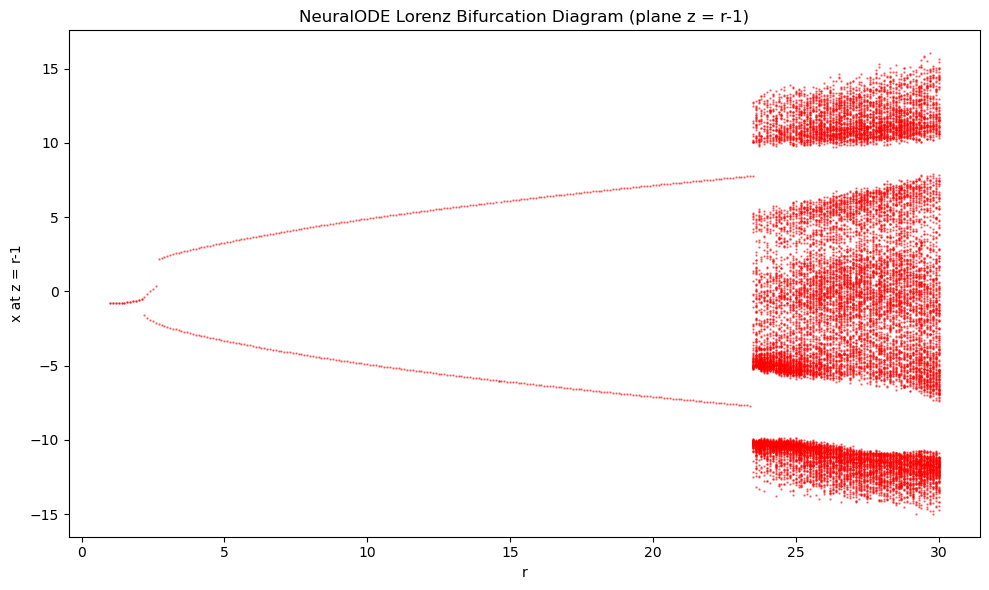

In [18]:
# Parameters
t_span = (0, 250)
dt = 0.1
t_eval = np.arange(t_span[0], t_span[1], dt)
warmup_time = 200

r_values = np.arange(1, 30.1, 0.1)
initial_conditions = [
    [1.0, 1.0, 1.0],
    [-1.0, -1.0, 1.0]
]

r_list_bif = []
x_list_bif = []

for r in r_values:
    print(f"Simulating NeuralODE for r = {r}")
    # Normalize r for the model
    r_norm = torch.tensor([(r - r_mean.item()) / r_std.item()], dtype=torch.float32).to(device)
    for init in initial_conditions:
        # Normalize initial condition
        init_norm = (torch.tensor(init, dtype=torch.float32) - x_mean) / x_std
        init_norm = init_norm.unsqueeze(0).to(device)  # shape [1, 3]
        t_tensor = torch.tensor(t_eval, dtype=torch.float32).to(device)
        # Set model parameter
        model.parameter_list = r_norm
        # Integrate
        with torch.no_grad():
            traj = odeint(model, init_norm, t_tensor, method='rk4', options={'step_size': 0.05})  # [T, 1, 3]
        traj = traj.squeeze(1).cpu().numpy()  # [T, 3]
        # Denormalize
        traj_denorm = traj * x_std.cpu().numpy() + x_mean.cpu().numpy()
        x = traj_denorm[:, 0]
        z = traj_denorm[:, 2]
        t = t_eval

        # Only consider after warmup
        mask = t > warmup_time
        t_post = t[mask]
        x_post = x[mask]
        z_post = z[mask]

        # Check for convergence: std of last 10% of x_post is small
        last_n = max(10, int(0.1 * len(x_post)))
        if np.std(x_post[-last_n:]) < 1e-2:  # You can adjust this threshold
            x_converged = np.mean(x_post[-last_n:])
            r_list_bif.append(r)
            x_list_bif.append(x_converged)
            continue  # Skip crossing detection if converged

        # Find all crossings of z = r-1
        z_plane = r - 1
        crossings = np.where((z_post[:-1] - z_plane) * (z_post[1:] - z_plane) <= 0)[0]
        for idx in crossings:
            frac = (z_plane - z_post[idx]) / (z_post[idx+1] - z_post[idx])
            x_cross = x_post[idx] + frac * (x_post[idx+1] - x_post[idx])
            r_list_bif.append(r)
            x_list_bif.append(x_cross)

# Plot bifurcation diagram
plt.figure(figsize=(10, 6))
plt.scatter(r_list_bif, x_list_bif, s=0.5, alpha=0.5, color="red")
plt.xlabel("r")
plt.ylabel("x at z = r-1")
plt.title("NeuralODE Lorenz Bifurcation Diagram (plane z = r-1)")
plt.tight_layout()
plt.show()

In [19]:
# Save r_list and x_list for reuse
torch.save({'r_list': r_list_bif, 'x_list': x_list_bif}, "lorenz_bifurcation_data_bif.pth")
print("Saved r_list and x_list to 'lorenz_bifurcation_data.pth'")

Saved r_list and x_list to 'lorenz_bifurcation_data.pth'


C:\Users\tegel009\AppData\Local\Temp\ipykernel_18024\72334691.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("lorenz_bifurcation_data.pth")


NameError: name 'r_list_bif' is not defined

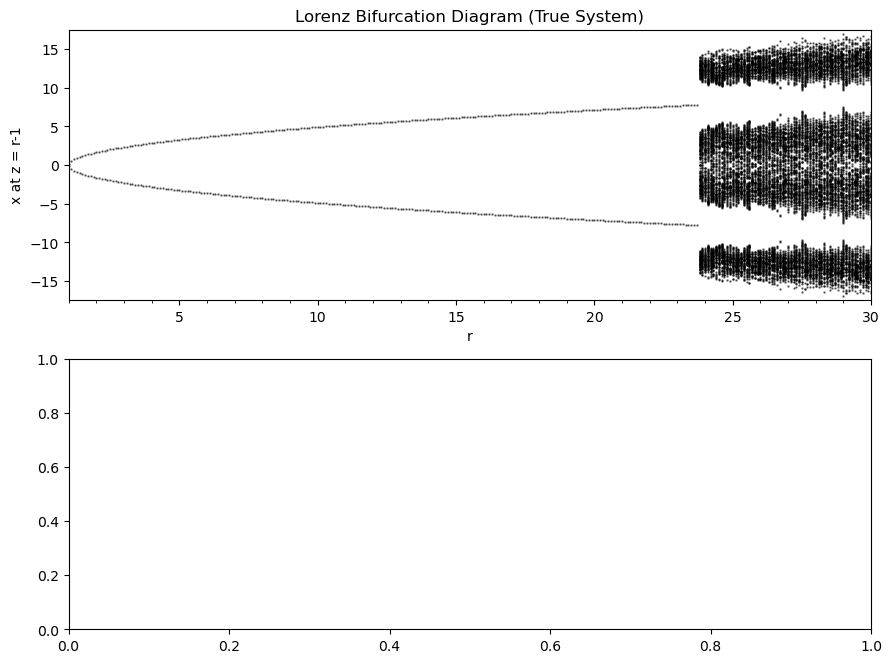

In [9]:
# Plot both bifurcation diagrams: true system and NeuralODE, stacked vertically
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(9, 6.5))

data = torch.load("lorenz_bifurcation_data.pth")
r_list = data['r_list']
x_list = data['x_list']

# Top plot: True Lorenz system
ax1=plt.subplot(2, 1, 1)
plt.scatter(r_list, x_list, s=0.6, alpha=0.5, color="black")
plt.xlabel("r")
plt.xlim(1, 30)
plt.ylim(-17.5, 17.5)
plt.ylabel("x at z = r-1")
plt.title("Lorenz Bifurcation Diagram (True System)")
ax1.xaxis.set_major_locator(ticker.FixedLocator([5, 10, 15, 20, 25, 30]))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax1.set_xticklabels(['5', '10', '15', '20', '25', '30'])

plt.savefig("bifurcation_diagram_2.png", dpi=300, transparent=True)
plt.tight_layout()


# Bottom plot: NeuralODE
ax2=plt.subplot(2, 1, 2)
plt.scatter(r_list_bif, x_list_bif, s=0.1, alpha=0.5, color="black")
plt.xlabel("r")
plt.ylabel("x at z = r-1")
plt.xlim(1, 30)
plt.ylim(-17.5, 17.5)
ax2.xaxis.set_major_locator(ticker.FixedLocator([5, 10, 15, 20, 25, 30]))
ax2.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax2.set_xticklabels(['5', '10', '15', '20', '25', '30'])
plt.title("Lorenz Bifurcation Diagram (NeuralODE)")
plt.tight_layout()
plt.savefig("bifurcation_diagram.png", dpi=300, transparent=True)
plt.show()

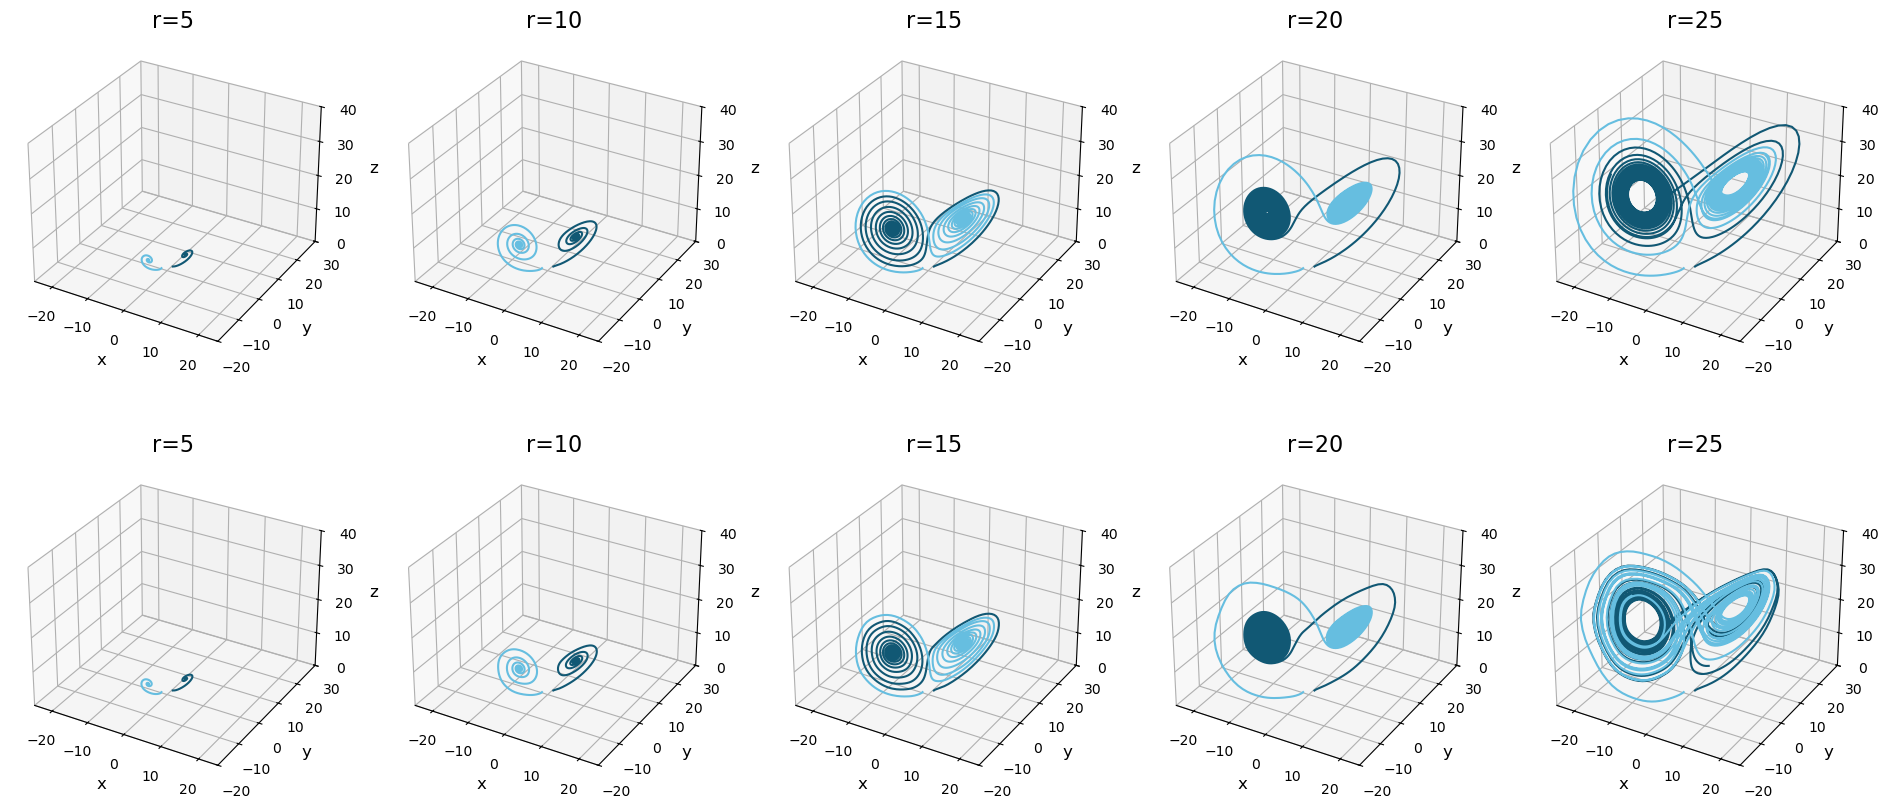

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import numpy as np
import torch

# Define r values and initial conditions
plot_r_values = [5, 10, 15, 20, 25]
initial_conditions = [
    [1.0, 1.0, 1.0],
    [-1.0, -1.0, 1.0]
]
colors = ["#115874", "#66BEE0"]
labels = ['[1,1,1]', '[-1,-1,1]']

t_plot = np.linspace(0, 20, 2000)

# --- True system trajectories ---
true_trajs = []
for init in initial_conditions:
    trajs = []
    for r in plot_r_values:
        sol = solve_ivp(
            lorenz, (0, 20), init, args=(sigma, beta, r),
            t_eval=t_plot, rtol=1e-8, atol=1e-10
        )
        trajs.append(sol.y)  # shape [3, T]
    true_trajs.append(trajs)  # shape [len(init), len(r), 3, T]

# --- NeuralODE trajectories ---
t_plot_torch = torch.tensor(t_plot, dtype=torch.float32).to(device)
plot_r_values_norm = ((torch.tensor(plot_r_values, dtype=torch.float32) - r_mean) / r_std).to(device)

neural_trajs = []
for init in initial_conditions:
    init_batch = torch.tensor([init] * len(plot_r_values), dtype=torch.float32)
    init_norm = ((init_batch - x_mean) / x_std).to(device)
    model.parameter_list = plot_r_values_norm
    with torch.no_grad():
        pred_traj = odeint(model, init_norm, t_plot_torch, method='rk4', options={'step_size': 0.005})  # [T, N, 3]
    pred_traj = pred_traj.cpu().numpy()  # [T, N, 3]
    pred_traj_denorm = pred_traj * x_std.cpu().numpy() + x_mean.cpu().numpy()
    neural_trajs.append(pred_traj_denorm)  # shape [len(init), T, N, 3]

# --- Plotting ---
fig = plt.figure(figsize=(20, 8))

# Top row: True system
for idx, r in enumerate(plot_r_values):
    ax = fig.add_subplot(2, len(plot_r_values), idx + 1, projection='3d')
    for ic_idx, color in enumerate(colors):
        traj = true_trajs[ic_idx][idx]  # [3, T]
        ax.plot(traj[0], traj[1], traj[2], color=color, label=labels[ic_idx])
    ax.set_title(f"r={r}", fontsize=16)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_zlabel("z", fontsize=12)
    ax.set_xlim([-25, 25])
    ax.set_ylim([-20, 30])
    ax.set_zlim([0, 40])
    

# Bottom row: NeuralODE
for idx, r in enumerate(plot_r_values):
    ax = fig.add_subplot(2, len(plot_r_values), len(plot_r_values) + idx + 1, projection='3d')
    for ic_idx, color in enumerate(colors):
        traj = neural_trajs[ic_idx][:, idx, :]  # [T, 3]
        ax.plot(traj[:, 0], traj[:, 1], traj[:, 2], color=color, label=labels[ic_idx])
    ax.set_title(f"r={r}", fontsize=16)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.set_zlabel("z", fontsize=12)
    ax.set_xlim([-25, 25])
    ax.set_ylim([-20, 30])
    ax.set_zlim([0, 40])
   

plt.tight_layout()
plt.subplots_adjust(hspace=0.3,wspace=-0.15)
#plt.savefig("trajectories_true_vs_neuralode.png", dpi=300, transparent=True)
plt.show()